In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms
from pathlib import Path

In [38]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [4]:
from torchvision.transforms import ToTensor

root_data = Path("data/")

train_data = datasets.MNIST(root=root_data,
                            train=True,
                            transform=ToTensor(),
                            download=True)

test_data = datasets.MNIST(root=root_data,
                           train=False,
                           transform=ToTensor(),
                           download=True)

In [26]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Text(0.5, 1.0, '5 - five')

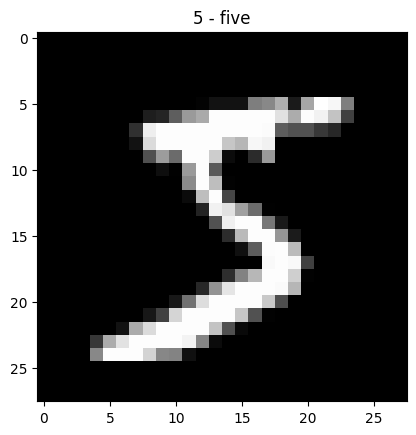

In [30]:
import matplotlib.pyplot as plt
image = train_data[0][0]
plt.imshow(image.permute(1, 2, 0), cmap="gray")
plt.title(class_names[train_data[0][1]])

In [32]:
from torch.utils.data import DataLoader 

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=1)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=1)

In [33]:
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [75]:
class MNIST_CNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=0.1)

In [97]:
def train_step(model,
               train_dataloader,
               loss_fn,
               optimizer,
               acc_fn):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to('mps'), y.to('mps')
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += acc_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    return train_loss, train_acc


In [101]:
def test_step(model,
              test_dataloader,
              loss_fn,
              acc_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader):
            X, y = X.to('mps'), y.to('mps')
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss
            acc = acc_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_acc += acc
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    return test_loss, test_acc

In [102]:
model = MNIST_CNN(input_shape=1,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [100]:
from tqdm.auto import tqdm

EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
    print(f"EPOCH: {epoch + 1}")
    train_loss, train_acc = train_step(model=model,
                                       train_dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       acc_fn=acc_fn)
    print(f"Train loss: {train_loss:.2f} | Train acc: {train_acc:.2f}")
    test_loss, test_acc = test_step(model=model,
                                    test_dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    acc_fn=acc_fn)
    print(f"Test loss: {test_loss:.2f} | Test acc: {test_acc:.2f}")
    

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1
Train loss: 0.25 | Train acc: 91.90


 10%|█         | 1/10 [00:12<01:53, 12.58s/it]

Test loss: 0.07 | Test acc: 97.74
EPOCH: 2
Train loss: 0.07 | Train acc: 97.77


 20%|██        | 2/10 [00:24<01:39, 12.40s/it]

Test loss: 0.06 | Test acc: 97.83
EPOCH: 3
Train loss: 0.06 | Train acc: 98.09


 30%|███       | 3/10 [00:37<01:27, 12.44s/it]

Test loss: 0.06 | Test acc: 98.14
EPOCH: 4
Train loss: 0.05 | Train acc: 98.44


 40%|████      | 4/10 [00:49<01:14, 12.45s/it]

Test loss: 0.05 | Test acc: 98.17
EPOCH: 5
Train loss: 0.04 | Train acc: 98.64


 50%|█████     | 5/10 [01:02<01:02, 12.52s/it]

Test loss: 0.04 | Test acc: 98.53
EPOCH: 6
Train loss: 0.04 | Train acc: 98.73
